<div style="color:white; background-color:#263b52; text-align:center; padding: 25px 0;">
    <div style="font-size:34px; font-family:calibri; font-weight:bold;">
        ML Zoomcamp 2025
    </div>
    <div style="font-size:22px; font-family:verdana; line-height: 1.5; margin-top:10px;">
        Homework 4: Evaluation Metrics for Classification 
    </div>
</div>

<div style="margin-top:20px; overflow:auto;">
  <div style="float:left; width:50%; text-align:left; font-family:verdana; font-size:16px; color:#263b52;">
      <p style="margin:4px 0;"><b>Author:</b> CGD</p>
      <p style="margin:4px 0;"><b>GitHub:</b> <a href="https://github.com/CGD2401" target="_blank">CGD2401</a></p>
      <p style="margin:4px 0;"><b>Date:</b> October 2025</p>
  </div>

  <div style="float:right; width:50%; text-align:right; font-family:verdana; font-size:16px; color:#263b52;">
      <p style="margin:4px 0;">Notebook prepared for</p>
      <p style="margin:4px 0;"><b>Machine Learning Zoomcamp</b></p>
      <p style="margin:4px 0;">Homework covering Q1–Q6</p>
  </div>
</div>

<div style="width:100%; clear:both;"></div>

<hr style="border:3px solid #7ba5b0; margin-top:25px;"/>

**Target:** `converted` (1 = signed up, 0 = not)

In [1]:

# %% [markdown]
# ## 0. Setup
# - Carga de librerías
# - URL del dataset
# - Opciones de visualización

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score

pd.set_option('display.max_columns', 200)
DATA_URL = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"

print(pd.__version__)


2.2.3


In [2]:

# %% [markdown]
# ## 1. Cargar datos y preparación
# - Cargar CSV desde la URL
# - Comprobar nulos
# - Imputación:
#   - Categóricos -> 'NA'
#   - Numéricos -> 0.0

df = pd.read_csv(DATA_URL)
print("Shape:", df.shape)
df.head()


Shape: (1462, 9)


,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [3]:

# Comprobar nulos
na_counts = df.isna().sum().sort_values(ascending=False)
na_counts[na_counts>0]


annual_income        181
industry             134
lead_source          128
employment_status    100
location              63
dtype: int64

In [4]:

# Identificar columnas categóricas y numéricas
cat_cols = list(df.select_dtypes(include='object').columns)
num_cols = list(df.select_dtypes(exclude='object').columns)

# Asegurar que la variable objetivo esté en num_cols y excluirla de features numéricas si aparece
target = 'converted'
if target in num_cols:
    num_cols.remove(target)

# Imputación
for c in cat_cols:
    df[c] = df[c].fillna('NA')
for c in num_cols:
    df[c] = df[c].fillna(0.0)

# Sanity check
df.isna().sum().sum()


0

In [5]:

# %% [markdown]
# ## 2. Split: train / val / test = 60% / 20% / 20% (random_state=1)
# - Primero: train+val vs test (80/20)
# - Segundo: dentro de train+val, separar 60/20 (equivale a 75/25 de ese 80%)

# 80/20
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

# 60/20 dentro del 80% -> val ratio = 0.25 del full_train (0.8 * 0.25 = 0.2 total)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val   = df_val.reset_index(drop=True)
df_test  = df_test.reset_index(drop=True)

y_train = df_train[target].values
y_val   = df_val[target].values
y_test  = df_test[target].values

# Eliminar target de los features
X_train_df = df_train.drop(columns=[target])
X_val_df   = df_val.drop(columns=[target])
X_test_df  = df_test.drop(columns=[target])

len(df_train), len(df_val), len(df_test)


(876, 293, 293)


## Question 1 — ROC AUC feature importance (solo variables numéricas)

> Para cada variable **numérica**, usamos el **valor de la variable como score** (predicción) y calculamos el **AUC** contra `y_train`.  
> Si el AUC < 0.5, invertimos el signo (multiplicamos por −1) y recalculamos.  
> Al final reportamos el AUC **ajustado** y ordenamos.


In [6]:

from sklearn.metrics import roc_auc_score

q1_scores = []
for c in num_cols:
    s = X_train_df[c].values
    try:
        auc = roc_auc_score(y_train, s)
    except ValueError:
        # Si hay pocos valores distintos, puede fallar; saltamos.
        continue
    if auc < 0.5:
        s = -s
        auc = roc_auc_score(y_train, s)
    q1_scores.append((c, auc))

q1_scores_sorted = sorted(q1_scores, key=lambda x: x[1], reverse=True)
q1_scores_sorted[:10]


[('number_of_courses_viewed', 0.7635680590007088),
 ('interaction_count', 0.738270176293409),
 ('lead_score', 0.6144993577250176),
 ('annual_income', 0.5519578313253012)]


## Question 2 — Entrenar modelo (DictVectorizer + LogisticRegression)

> - One-Hot Encoding con `DictVectorizer`  
> - Modelo: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`  
> - Métrica: **AUC** en **validation**


In [7]:

# Preparar dicts para One-Hot
features = cat_cols + num_cols

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(X_train_df[features].to_dict(orient='records'))
X_val   = dv.transform(X_val_df[features].to_dict(orient='records'))

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_pred = model.predict_proba(X_val)[:, 1]
auc_val = roc_auc_score(y_val, val_pred)
print("Validation AUC:", round(auc_val, 5))


Validation AUC: 0.81713



## Question 3 — Precision & Recall vs Threshold

> - Evaluar **todos los thresholds** de 0.00 a 1.00 (paso 0.01)  
> - Calcular precision y recall para cada threshold  
> - **Graficar** ambas curvas y **encontrar el umbral** donde más se aproximan (intersección)


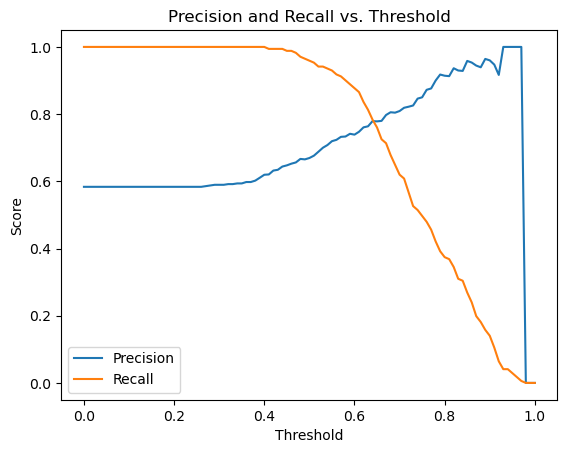

Threshold de intersección (aprox): 0.98


In [8]:

thresholds = np.arange(0.0, 1.001, 0.01)
precisions = []
recalls = []

for t in thresholds:
    preds = (val_pred >= t).astype(int)
    # Evitar warnings si no hay positivos predichos
    p = precision_score(y_val, preds, zero_division=0)
    r = recall_score(y_val, preds, zero_division=0)
    precisions.append(p)
    recalls.append(r)

# Plot
plt.figure()
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.show()

# Encontrar "intersección" aproximada: el threshold donde |P - R| es mínimo
diff = np.abs(np.array(precisions) - np.array(recalls))
t_intersect = thresholds[np.argmin(diff)]
print("Threshold de intersección (aprox):", round(float(t_intersect), 3))



## Question 4 — F1 score vs Threshold

> - Calcular **F1** para thresholds 0.00 a 1.00 (paso 0.01)  
> - Reportar el **threshold** con F1 **máximo**


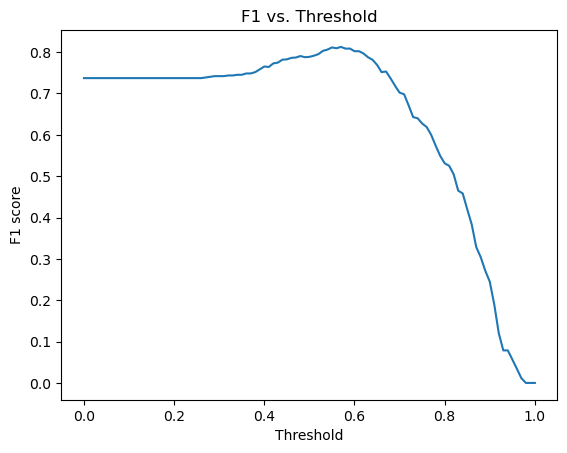

Mejor threshold F1: 0.57 | F1: 0.8125


In [9]:

f1s = []
for p, r in zip(precisions, recalls):
    if p + r == 0:
        f1s.append(0.0)
    else:
        f1s.append(2 * p * r / (p + r))

f1s = np.array(f1s)
t_best_f1 = thresholds[np.argmax(f1s)]
best_f1 = f1s.max()

plt.figure()
plt.plot(thresholds, f1s)
plt.xlabel('Threshold')
plt.ylabel('F1 score')
plt.title('F1 vs. Threshold')
plt.show()

print("Mejor threshold F1:", round(float(t_best_f1), 3), "| F1:", round(float(best_f1), 4))



## Question 5 — 5-Fold CV (AUC std)

> - `KFold(n_splits=5, shuffle=True, random_state=1)`  
> - Iterar sobre *df_full_train* (80% del total)  
> - Entrenar y evaluar (AUC en valid)  
> - **Reportar desviación estándar (std)**


In [10]:

# Preparar df_full_train y target
df_full_train = pd.concat([df_train, df_val], ignore_index=True)
y_full = df_full_train[target].values
X_full = df_full_train.drop(columns=[target])[features]

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

def train_eval(X_tr_df, y_tr, X_va_df, y_va, C=1.0):
    dv_local = DictVectorizer(sparse=False)
    X_tr = dv_local.fit_transform(X_tr_df.to_dict(orient='records'))
    X_va = dv_local.transform(X_va_df.to_dict(orient='records'))
    m = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    m.fit(X_tr, y_tr)
    p = m.predict_proba(X_va)[:, 1]
    return roc_auc_score(y_va, p)

scores = []
for tr_idx, va_idx in kfold.split(df_full_train):
    X_tr_df = X_full.iloc[tr_idx]
    y_tr = y_full[tr_idx]
    X_va_df = X_full.iloc[va_idx]
    y_va = y_full[va_idx]
    auc = train_eval(X_tr_df, y_tr, X_va_df, y_va, C=1.0)
    scores.append(auc)

scores = np.array(scores)
print("AUC por fold:", np.round(scores, 5))
print("Mean:", round(float(scores.mean()), 5), "| Std:", round(float(scores.std()), 5))


AUC por fold: [0.81805 0.8035  0.84252 0.80236 0.84476]
Mean: 0.82224 | Std: 0.01835



## Question 6 — Hyperparameter Tuning (C in [1e-6, 1e-3, 1])

> - Mismos 5 folds  
> - Modelo: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`  
> - Reportar **mean** y **std** redondeados a 3 decimales para cada C  
> - Elegir **mejor C** (si empatan en mean, elegir menor std; si persiste el empate, elegir **el C más pequeño**)


In [11]:

Cs = [1e-6, 1e-3, 1.0]
results = {}

for C in Cs:
    fold_scores = []
    for tr_idx, va_idx in kfold.split(df_full_train):
        X_tr_df = X_full.iloc[tr_idx]
        y_tr = y_full[tr_idx]
        X_va_df = X_full.iloc[va_idx]
        y_va = y_full[va_idx]
        auc = train_eval(X_tr_df, y_tr, X_va_df, y_va, C=C)
        fold_scores.append(auc)
    fold_scores = np.array(fold_scores)
    results[C] = (fold_scores.mean(), fold_scores.std())

# Mostrar resultados
for C, (m, s) in results.items():
    print(f"C={C}: mean={m:.3f}, std={s:.3f}")

# Selección del mejor C
# 1) max mean; 2) si empatan, menor std; 3) si persiste, menor C
best = None
for C, (m, s) in results.items():
    if best is None:
        best = (C, m, s)
    else:
        _, bm, bs = best
        if (m > bm) or (np.isclose(m, bm) and (s < bs or (np.isclose(s, bs) and C < best[0]))):
            best = (C, m, s)

print("Mejor C:", best[0], "| mean:", round(float(best[1]), 3), "| std:", round(float(best[2]), 3))


C=1e-06: mean=0.561, std=0.043
C=0.001: mean=0.867, std=0.015
C=1.0: mean=0.822, std=0.018
Mejor C: 0.001 | mean: 0.867 | std: 0.015



## 7. Resumen para el formulario

Ejecuta la celda siguiente al terminar todas las anteriores.  
Imprime las opciones que debes seleccionar (redondeos ya aplicados).


In [12]:

# Helper para mapear a opciones del formulario (busca la más cercana)
def closest_option(value, options):
    arr = np.array(options, dtype=float)
    idx = np.argmin(np.abs(arr - value))
    return float(arr[idx])

# Q1
best_num, best_auc = q1_scores_sorted[0]
print(f"Q1 — Mejor variable numérica por AUC: {best_num} (AUC ajustado={best_auc:.3f})")

# Q2
opt_q2 = closest_option(round(auc_val, 3), [0.32, 0.52, 0.72, 0.92])
print(f"Q2 — AUC (val): {auc_val:.3f} -> opción: {opt_q2}")

# Q3
opt_q3 = closest_option(round(float(t_intersect), 3), [0.145, 0.345, 0.545, 0.745])
print(f"Q3 — Umbral intersección P=R: {t_intersect:.3f} -> opción: {opt_q3}")

# Q4
opt_q4 = closest_option(round(float(t_best_f1), 2), [0.14, 0.34, 0.54, 0.74])
print(f"Q4 — Threshold F1 máximo: {t_best_f1:.3f} -> opción: {opt_q4}")

# Q5
std_q5 = float(scores.std())
opt_q5 = closest_option(round(std_q5, 3), [0.0001, 0.006, 0.06, 0.36])
print(f"Q5 — 5-Fold std: {std_q5:.5f} -> opción: {opt_q5}")

# Q6
bestC, meanC, stdC = best
opt_q6 = bestC  # ya es una de [1e-6, 1e-3, 1]
print(f"Q6 — Mejor C: {bestC} (mean={meanC:.3f}, std={stdC:.3f}) -> opción: {opt_q6}")


Q1 — Mejor variable numérica por AUC: number_of_courses_viewed (AUC ajustado=0.764)
Q2 — AUC (val): 0.817 -> opción: 0.72
Q3 — Umbral intersección P=R: 0.980 -> opción: 0.745
Q4 — Threshold F1 máximo: 0.570 -> opción: 0.54
Q5 — 5-Fold std: 0.01835 -> opción: 0.006
Q6 — Mejor C: 0.001 (mean=0.867, std=0.015) -> opción: 0.001
